# CIS6800: Project 2: YOLO
### Due:
* Part A - Sept. 18 at 11:59 p.m.
* Part B - Sept. 25 at 11:59 p.m.

### Instructions:
* Part A consists of parts 1-4 and is due on September 18th at 11:59 p.m. EDT.
* Part B consists of parts 5-8 and is due on September 25th at 11:59 p.m. EDT.
* As the autograder uses the definitions for functions and classes you submit,
please do not modify the name of any function or class provided.
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.

## Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>
<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we provide 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large, so we do not expect you to learn a super robust object detector.

## Data Preprocessing
For this section, you will need to write code to preprocess the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>
<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, you are required to convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The instructions of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, you need to convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), you donâ€™t need to assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

## Model Architecture
You are required to implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


## Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} = 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} + 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} + 
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} + 
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} + 
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2}$$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, you can set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. You are encourage to adaptively adjust learning rate during training to see if the model will converge better. You should also visualize the loss over training iterations. You will need to decide at the iteration to stop training based on the loss visualization. (At least 20 epochs of training is required.)

## Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of your YOLO implementation, compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of your network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>
<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

## Code

## Initialise

In [1]:
!pip install pytorch_lightning &> /dev/null

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split,Dataset, TensorDataset
import torchvision.transforms as transforms
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [2]:
import torchvision
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning import callbacks as pl_callbacks

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Use this function to import the provided data files
def load_data(file_name):
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']
 
images = load_data('/content/drive/MyDrive/680/images.npz')
raw_labels = load_data('/content/drive/MyDrive/680/labels.npz')
# images      = load_data('images.npz')
# raw_labels  = load_data('labels.npz')

## PROCESS LABELS

In [5]:
'''
The find Centers function takes the ground labels as inputs.
Returns the anchors: The positions of anchor box
                     The true centers corresponding that particular grid 
                     The widht and height of the anchor boxes
'''
def find_anch_centers_dim(gnd_labels):
  #Center given coordinates
  x1, y1, x2, y2 = gnd_labels
  x_width  = np.abs(x2 - x1) / 128
  y_width  = np.abs(y2 - y1) / 128
  
  x_center = (x1 + x2) /2
  y_center = (y1 + y2) /2
  
  #Index of the anchor box
  x_anchor = x_center // 16
  y_anchor = y_center // 16

  x_true_center = (x_center / 16) - x_anchor
  y_true_center = (y_center / 16) - y_anchor

  return x_anchor, y_anchor, x_true_center, y_true_center, x_width, y_width

# This function should compute the 8X8X8 label from the raw labels for the corresponding image.
def process_labels(raw_labels):
  #define an empty Array of 8x8x8
  #Note the function takes NxM of raw labels of inputs where N corresponds to the number of raw labels and each label has M bounding boxes
  labels = []
  for label in raw_labels:
    new_label                 = np.zeros((8,8,8))
    
    #call the centers function iteratively for every anchor box in the given label in the loop
    a_box                     = np.apply_along_axis(find_anch_centers_dim, 1, label[:, 1:])
    indexes                   = np.arange(0,a_box.shape[0])

    #The first column of labels corresponds to the Probability of the class (car / pedestrian / traffic light)    
    ret_labels_classes        = label[indexes][:, 0].astype(int).reshape(-1,1)
    
    #the anchors and center widths are the corresponding columns returned from the find_anch_centers_dim function.
    ret_labels_anchors        = a_box[indexes][:,:2].astype(int)
    ret_labels_centers_widths = a_box[indexes][:,2:]
    #The one hot matrix is based on the class (car / pedestrian / traffic light). We just define a '1' wherever that particular object exists. Else 0.
    one_hot_mat               = np.zeros((ret_labels_classes.shape[0], 3))
    one_hot_mat               = np.where(ret_labels_classes==2, np.array([0, 0, 1]), one_hot_mat)
    one_hot_mat               = np.where(ret_labels_classes==1, np.array([0, 1, 0]), one_hot_mat)
    one_hot_mat               = np.where(ret_labels_classes==0, np.array([1, 0, 0]), one_hot_mat)

    mid                       = np.hstack((np.ones_like(ret_labels_classes),ret_labels_centers_widths, one_hot_mat))

    new_label[0,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,0]
    new_label[1,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,1]
    new_label[2,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,2]
    new_label[3,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,3]
    new_label[4,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,4]
    new_label[5,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,5]
    new_label[6,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,6]
    new_label[7,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,7]

    labels.append(new_label)

  return labels

## RECONSTRUCTION

In [6]:
# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels(labels, img_dim=128):
  recon_labels = []
  i = 0
  for label in labels:
    # label = label.detach().numpy()
    index         = np.where(np.vstack(np.stack(label[:],-1))[:,0] == 1)[0]
    valid_label   = np.vstack(np.stack(label[:],-1))[index]
    one_hot_mat   = valid_label[:,5:]
    
    _, class_prob = np.where(one_hot_mat == 1)

    x_ind, y_ind  = np.where(label[0] == 1)
    x_centers     = (valid_label[:,1] * 16) + (x_ind * 16)
    y_centers     = (valid_label[:,2] * 16) + (y_ind * 16)
    widths        = valid_label[:,3] * img_dim
    heights       = valid_label[:,4] * img_dim

    x1        = (x_centers - widths/2)
    x2        = (x_centers + widths/2)
    y1        = (y_centers - heights/2)  
    y2        = (y_centers + heights/2)  

    
    positions = np.vstack((class_prob,x1,y1,x2,y2)).T
    recon_labels.append(positions)
  recon_labels = [torch.tensor(rec) for rec in recon_labels]
  # recon_labels.requires_grad = True
  return recon_labels


## The Entire Loss Function


In [7]:
'''
This function should perform the inverse operation of process_labels(). 
Also this function is specificly defined for the yolo loss function.
It handels cases where the Output Images do not have bounding boxes (but the Target Images Do)
'''
def reconstruct_raw_labels_for_loss(labels, indexes, class_prob, output, img_dim=128):
  recon_labels = []
  if output == 'False':
    new_class_prob = []
    new_indexes    = []
    for label in labels:
      # label = label.detach().numpy()
      label = label.cpu().detach().numpy()
      indexes       = np.where(np.vstack(np.stack(label[:],-1))[:,0] != 0)[0]
      valid_label   = np.vstack(np.stack(label[:],-1))[indexes]
      one_hot_mat   = valid_label[:,5:]
      
      # _, class_prob = np.where(one_hot_mat == 1)
      class_prob = np.argmax(one_hot_mat,axis = -1)
      # print(class_prob)
      x_ind, y_ind  = np.where(label[0] != 0)
      x_centers     = (valid_label[:,1] * 16) + (x_ind * 16)
      y_centers     = (valid_label[:,2] * 16) + (y_ind * 16)
      widths        = valid_label[:,3] * img_dim
      heights       = valid_label[:,4] * img_dim

      x1        = (x_centers - widths/2)
      x2        = (x_centers + widths/2)
      y1        = (y_centers - heights/2)  
      y2        = (y_centers + heights/2)  

      positions = np.vstack((class_prob,x1,y1,x2,y2)).T
      
      recon_labels.append(positions)
      new_class_prob.append(class_prob)
      new_indexes.append(indexes)
    
    recon_labels = [torch.tensor(rec) for rec in recon_labels]
    return recon_labels, new_indexes, new_class_prob

  elif output == 'True':
    i = 0
    for label in labels:
      # label = label.detach().numpy()
      label = label.cpu().detach().numpy()
      new_indexes_2 = [ind for ind in indexes[i]]
      valid_label   = np.vstack(np.stack(label[:],-1))[new_indexes_2]
      one_hot_mat   = valid_label[:,5:]

      x_ind         = np.array([int(i/8) for i in new_indexes_2])
      y_ind         = np.array([int(i%8) for i in new_indexes_2])
      x_centers     = (valid_label[:,1] * 16) + (x_ind * 16)
      y_centers     = (valid_label[:,2] * 16) + (y_ind * 16)
      widths        = valid_label[:,3] * img_dim
      heights       = valid_label[:,4] * img_dim

      x1        = (x_centers - widths/2)
      x2        = (x_centers + widths/2)
      y1        = (y_centers - heights/2)  
      y2        = (y_centers + heights/2)  

      positions = np.vstack((class_prob[i],x1,y1,x2,y2)).T
      recon_labels.append(positions)
      i+=1

    recon_labels = [torch.tensor(rec) for rec in recon_labels]
    return recon_labels, new_indexes_2, class_prob

In [8]:
'''
The Intersection over union is defined here. 
It inputs the edges of the output and target respectively and computes the intersection area/ union area
'''
def IOU(output_edges ,target_edges, epsilon = 1e-3):
  
  if len(output_edges) == 0 or len(target_edges) == 0:
    iou = [0]
    return iou
  else:   
    zeros     = torch.zeros(output_edges.shape[0])
    x1_max    = torch.max(output_edges[:,0],target_edges[:,0])
    y1_max    = torch.max(output_edges[:,1],target_edges[:,1])
    x2_max    = torch.min(output_edges[:,2],target_edges[:,2])
    y2_max    = torch.min(output_edges[:,3],target_edges[:,3])
    
    inter_area = torch.max(zeros,x2_max - x1_max) * torch.max(zeros,y2_max - y1_max)

    op_area   = (output_edges[:,2] - output_edges[:,0]) * (output_edges[:,3] - output_edges[:,1])
    tar_area  = (target_edges[:,2] - target_edges[:,0]) * (target_edges[:,3] - target_edges[:,1])

    iou = inter_area/(op_area + tar_area - inter_area + epsilon)
    iou = torch.clamp(iou, min=0, max=1)
    return iou

In [9]:
'''
The calculate_IOU calls the IOU function above in a loop.
Since we are handling multiple outputs and targets at once in the main YoloLoss function
'''
def calculate_IOU(output, target):

  IOU_mat         = np.zeros((output.shape[0], 8, 8))
  indxs           = torch.where(target[:, 0, :, :] != 0)

  indexes = np.array([0])
  class_prob = np.array([0])
  
  tar_reconstruct, indexes, class_prob = reconstruct_raw_labels_for_loss(target, indexes, class_prob, 'False')
  op_reconstruct, indexes, class_prob  = reconstruct_raw_labels_for_loss(output, indexes, class_prob, 'True')

  for i in range(len(target)):
    new_op  = op_reconstruct[i]
    new_tar = tar_reconstruct[i]
    dummy   = IOU(new_op[:,1:], new_tar[:,1:])
    
    for j in range(len(dummy)):    
      IOU_mat[indxs[0][j], indxs[1][j], indxs[2][j]] = dummy[j]

  return torch.from_numpy(IOU_mat)

In [10]:
def yolo_loss(output, target):
    lambda_coor = 5
    lambda_noobj = 0.5

    first_term  = torch.zeros((len(output), 1))
    second_term = torch.zeros((len(output), 1))
    third_term  = torch.zeros((len(output), 1))
    fourth_term = torch.zeros((len(output), 1))
    fifth_term  = torch.zeros((len(output), 1))

    first_term    = lambda_coor * torch.sum(torch.sum((target[:, 0, :, :] * ((torch.square(output[:, 1, :, :] - target[:, 1, :, :])) + \
                                                              torch.square(output[:, 2, :, :] - target[:, 2, :, :]))),-1), -1)
    
    second_term   = lambda_coor * torch.sum(torch.sum(target[:, 0, :, :] * ((torch.square(torch.sqrt(output[:, 3, :, :]) - torch.sqrt(target[:, 3, :, :]))) + \
                                                                             torch.square(torch.sqrt(output[:, 4, :, :]) - torch.sqrt(target[:, 4, :, :]))), -1), -1)
    
    IOU_mat       = calculate_IOU(output, target).to(device)
    third_term    = torch.sum(torch.sum(target[:, 0, :, :] * torch.square((target[:, 0, :, :] * 1) - output[:, 0, :, :]), -1), -1)

    fourth_term   = lambda_noobj * torch.sum(torch.sum((1 - target[:, 0, :, :]) * torch.square((target[:, 0, :, :] * 0) - output[:, 0, :, :]), -1), -1)

    fifth_term    = torch.sum(torch.sum(target[:, 0, :, :] * torch.sum(torch.square(target[:, 5:, :, :] - output[:, 5:, :, :]), axis=1), -1), -1)

    loss = first_term + second_term + third_term + fourth_term + fifth_term
    # print('loss1',first_term)
    # print('loss2',second_term)
    # print('loss3',third_term)
    # print('loss4',fourth_term)
    # print('loss5',fifth_term)
    loss = torch.sum(loss)
    return loss.float()

## Model Definition

### Create Data for the Model

In [17]:
reshaped_imgs = np.transpose(images,(0,3,1,2))
new_images = torch.stack([torch.tensor(img, dtype = torch.float32) for img in reshaped_imgs])
# random_indices = torch.randperm(new_images.size()[0])
# new_images = new_images[random_indices]
new_images = new_images.float()

new_labels = process_labels(raw_labels)
new_labels_re = torch.stack([torch.tensor(label, dtype = torch.float32) for label in new_labels])

train_len = 0.8
eval_len  = 0.2

train_size  = int(train_len * len(new_images))
eval_size   = int(eval_len  * len(new_images))

train_data    = new_images[:train_size]
train_labels  = new_labels_re[:train_size] 

eval_data     = new_images[train_size:]
eval_labels   = new_labels_re[train_size:]

training_set    = torch.utils.data.TensorDataset(train_data, train_labels)
trainloader     = torch.utils.data.DataLoader(training_set, shuffle=False, batch_size=20)
evaluation_set  = torch.utils.data.TensorDataset(eval_data, eval_labels)
evalloader      = torch.utils.data.DataLoader(evaluation_set, shuffle=False, batch_size=20)

In [ ]:
# reshaped_imgs = np.transpose(images,(0,3,1,2))
# new_images = torch.stack([torch.tensor(img, dtype = torch.float32) for img in reshaped_imgs])

# random_indices = torch.randperm(new_images.size()[0])

# new_images = new_images[random_indices]
# new_images = new_images.float()

# new_labels = process_labels(raw_labels[random_indices])

# new_labels_re = torch.stack([torch.tensor(label, dtype = torch.float32) for label in new_labels])


# train_len = 0.8
# eval_len  = 0.2

# train_size  = int(train_len * len(new_images))
# eval_size   = int(eval_len  * len(new_images))

# train_size  = int(train_len * len(new_images))
# eval_size   = int(eval_len  * len(new_images))

# train_data    = new_images[:train_size]
# train_labels  = new_labels_re[:train_size] 

# eval_data     = new_images[train_size:]
# eval_labels   = new_labels_re[train_size:]

# training_set    = torch.utils.data.TensorDataset(train_data, train_labels)
# trainloader     = torch.utils.data.DataLoader(training_set, shuffle=False, batch_size=20)
# evaluation_set  = torch.utils.data.TensorDataset(eval_data, eval_labels)
# evalloader      = torch.utils.data.DataLoader(evaluation_set, shuffle=False, batch_size=20)

### Defining the Model

In [12]:
class YOLO(pl.LightningModule):
    def __init__(self):
        super(YOLO,self).__init__() 

        ###TRAIN
        self.nms_predicted_train_labels = []
        self.nms_target_train_labels    = []
        
        self.train_loss         = []
        self.train_predstore    = []
        self.train_targetstore  = []

        self.cl0_batch = []
        self.cl1_batch = []
        self.cl2_batch = []

        self.train_final_recall    = []
        self.train_final_precision = []

        self.train_recall_cl0, self.train_precision_cl0 = [], []
        self.train_recall_cl1, self.train_precision_cl1 = [], []
        self.train_recall_cl2, self.train_precision_cl2 = [], []
        self.train_map, self.train_final_map = [], []

        ##VAL
        self.nms_predicted_val_labels = []  
        self.nms_target_val_labels    = []

        self.val_loss      = []
        self.val_predstore    = []
        self.val_targetstore  = []

        self.cl0_val_batch = []
        self.cl1_val_batch = []
        self.cl2_val_batch = []

        self.val_final_recall    = []
        self.val_final_precision = []

        self.val_recall_cl0, self.val_precision_cl0 = [], []
        self.val_recall_cl1, self.val_precision_cl1 = [], []
        self.val_recall_cl2, self.val_precision_cl2 = [], []

        self.val_map, self.val_final_map = [], []

        self.conv_1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(4,4),stride = 2, padding=1)
        self.bnorm1 = torch.nn.BatchNorm2d(32)

        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4,4),stride = 2, padding=1)
        self.bnorm2 = torch.nn.BatchNorm2d(64)

        self.conv_3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4,4),stride = 2, padding=1)
        self.bnorm3 = torch.nn.BatchNorm2d(128)

        self.conv_4 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4,4),stride = 2, padding=1)
        self.bnorm4 = torch.nn.BatchNorm2d(256)
        
        self.conv_5 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4,4),stride = 2, padding=1)
        self.bnorm5 = torch.nn.BatchNorm2d(512)
        
        self.conv_6 = torch.nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(4,4),stride = 2, padding=1)
        self.bnorm6 = torch.nn.BatchNorm2d(1024)

        self.conv_7  = nn.ConvTranspose2d(in_channels = 1024,out_channels = 256,kernel_size = (4,4), stride = 2, padding = 1)
        self.bnorm7 = torch.nn.BatchNorm2d(256)

        self.conv_8  = nn.ConvTranspose2d(in_channels = 256,out_channels = 64,kernel_size = (4,4), stride = 2, padding = 1)
        self.bnorm8 = torch.nn.BatchNorm2d(64)

        self.conv_9  = nn.Conv2d(in_channels = 64,out_channels = 8,kernel_size = (3,3), stride = 1, padding = 1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bnorm1(self.conv_1(x)))
        x = self.relu(self.bnorm2(self.conv_2(x)))
        x = self.relu(self.bnorm3(self.conv_3(x)))
        x = self.relu(self.bnorm4(self.conv_4(x)))
        x = self.relu(self.bnorm5(self.conv_5(x)))
        x = self.relu(self.bnorm6(self.conv_6(x)))
        x = self.relu(self.bnorm7(self.conv_7(x)))
        x = self.relu(self.bnorm8(self.conv_8(x)))
        self.new = self.sig(self.conv_9(x))
        return self.new

    def training_step(self, batch, batch_idx):
        image, label  = batch
        y_predicted   = self.forward(image)
        loss          = yolo_loss(y_predicted, label)

        self.log("Train_loss", loss, prog_bar=True, on_epoch=True)
        return {'loss': loss, 'y_predicted':y_predicted, 'label':label} #'nms_predicted_labels':self.nms_predicted_train_labels, 'nms_target_labels':self.nms_target_train_labels}


    def training_epoch_end(self, outputs):
        avg_train_loss         = torch.stack([x['loss'] for x in outputs]).mean()
        self.train_loss.append(avg_train_loss)

        nms_predicted_labels_first         = torch.stack([x['y_predicted'] for x in outputs])
        nms_target_labels_first            = torch.stack([x['label'] for x in outputs])


        nms_predicted_labels_new = torch.tensor([]).to(device)
        nms_target_labels_new    = torch.tensor([]).to(device)
        for each_batch in nms_predicted_labels_first:
            nms_predicted_labels_new = torch.cat((nms_predicted_labels_new,each_batch))
        for each_batch in nms_predicted_labels_first:
            nms_target_labels_new = torch.cat((nms_target_labels_new,each_batch))

        nms_predicted_labels  = non_max_suppression(nms_predicted_labels_new)
        nms_target_labels     = reconstruct_batch(nms_target_labels_new)

        self.train_map.append(mean_average_precision(nms_predicted_labels, nms_target_labels))
        self.cl0_batch.append(average_precision(nms_predicted_labels, nms_target_labels, 0))
        self.cl1_batch.append(average_precision(nms_predicted_labels, nms_target_labels, 1))
        self.cl2_batch.append(average_precision(nms_predicted_labels, nms_target_labels, 2))
      
        if self.current_epoch == 39:
          rec_cl0, prec_cl0 = precision_recall_curve(nms_predicted_labels, nms_target_labels, 0)
          rec_cl1, prec_cl1 = precision_recall_curve(nms_predicted_labels, nms_target_labels, 1)
          rec_cl2, prec_cl2 = precision_recall_curve(nms_predicted_labels, nms_target_labels, 2)

          self.train_recall_cl0.append(rec_cl0)
          self.train_precision_cl0.append(prec_cl0)

          self.train_recall_cl1.append(rec_cl1)
          self.train_precision_cl1.append(prec_cl1)

          self.train_recall_cl2.append(rec_cl2)
          self.train_precision_cl2.append(prec_cl2)

          self.train_predstore   = torch.stack([x['y_predicted'] for x in outputs])
          self.train_targetstore = torch.stack([x['label'] for x in outputs])
  
    def validation_step(self, batch, batch_idx):
        val_image, val_label = batch
        val_y_predicted = self.forward(val_image)
        loss = yolo_loss(val_y_predicted, val_label)

        self.log('Val_loss',loss)
        return {'loss': loss, 'val_y_predicted':val_y_predicted, 'val_label':val_label} #'nms_predicted_val_labels':self.nms_predicted_val_labels, 'nms_target_val_labels':self.nms_target_val_labels}

    def validation_epoch_end(self, outputs):
        avg_val_loss          = torch.stack([x['loss'] for x in outputs]).mean()
        self.val_loss.append(avg_val_loss)

        val_nms_predicted_labels_first         = torch.stack([x['val_y_predicted'] for x in outputs])
        val_nms_target_labels_first            = torch.stack([x['val_label'] for x in outputs])

        val_nms_predicted_labels_new = torch.tensor([]).to(device)
        val_nms_target_labels_new    = torch.tensor([]).to(device)
        for each_batch in val_nms_predicted_labels_first:
            val_nms_predicted_labels_new = torch.cat((val_nms_predicted_labels_new,each_batch))
        for each_batch in val_nms_target_labels_first:
            val_nms_target_labels_new = torch.cat((val_nms_target_labels_new,each_batch))

        val_nms_predicted_labels = non_max_suppression(val_nms_predicted_labels_new)
        val_nms_target_labels    = reconstruct_batch(val_nms_target_labels_new)

        self.cl0_val_batch.append(average_precision(val_nms_predicted_labels, val_nms_target_labels, 0))
        self.cl1_val_batch.append(average_precision(val_nms_predicted_labels, val_nms_target_labels, 1))
        self.cl2_val_batch.append(average_precision(val_nms_predicted_labels, val_nms_target_labels, 2))
        self.val_map.append(mean_average_precision(val_nms_predicted_labels, val_nms_target_labels))

        if self.current_epoch == 39:
          rec_cl0, prec_cl0 = precision_recall_curve(val_nms_predicted_labels, val_nms_target_labels, 0)
          rec_cl1, prec_cl1 = precision_recall_curve(val_nms_predicted_labels, val_nms_target_labels, 1)
          rec_cl2, prec_cl2 = precision_recall_curve(val_nms_predicted_labels, val_nms_target_labels, 2)

          self.val_recall_cl0.append(rec_cl0)
          self.val_precision_cl0.append(prec_cl0)

          self.val_recall_cl1.append(rec_cl1)
          self.val_precision_cl1.append(prec_cl1)

          self.val_recall_cl2.append(rec_cl2)
          self.val_precision_cl2.append(prec_cl2)

          self.val_predstore   = torch.stack([x['val_y_predicted'] for x in outputs])
          self.val_targetstore = torch.stack([x['val_label'] for x in outputs])

    def configure_optimizers(self):
        optimizer  = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.001)
        return optimizer

## Nms

In [14]:
def reconstruct_batch(true_labels):

  reconstructed_true_labels = []
  
  for each_label in true_labels:

    each_label = each_label.cpu().detach().numpy()
    each_label = np.vstack(np.stack(each_label,axis = -1))
    x_ind         = np.array([int(i/8) for i in each_label[:,-1]])
    y_ind         = np.array([int(i%8) for i in each_label[:,-1]])

    x_centers     = (each_label[:,1] * 16) + (x_ind * 16)
    y_centers     = (each_label[:,2] * 16) + (y_ind * 16)
    widths        = each_label[:,3] * 128
    heights       = each_label[:,4] * 128

    x1        = (x_centers - widths/2)
    x2        = (x_centers + widths/2)
    y1        = (y_centers - heights/2)  
    y2        = (y_centers + heights/2) 
    class_prob= np.argmax(each_label[:,5:],axis = 1).T
  
    label_op = torch.tensor(np.vstack((class_prob,each_label[:,0].T,x1,y1,x2,y2)).T)
    label_op = label_op[torch.where(label_op[:, 1] != 0)]
    # print("label_op", label_op.shape)
    reconstructed_true_labels.append(label_op)
  # reconstructed_true_labels = torch.stack(reconstructed_true_labels)
  
  return reconstructed_true_labels
  

def reconstruct_nms(label):

  x_ind         = np.array([int(i/8) for i in label[:,-1]])
  y_ind         = np.array([int(i%8) for i in label[:,-1]])

  x_centers     = (label[:,1] * 16) + (x_ind * 16)
  y_centers     = (label[:,2] * 16) + (y_ind * 16)
  widths        = label[:,3] * 128
  heights       = label[:,4] * 128

  x1        = (x_centers - widths/2)
  x2        = (x_centers + widths/2)
  y1        = (y_centers - heights/2)  
  y2        = (y_centers + heights/2) 
  class_prob= np.argmax(label[:,5:],axis = 1).T
  return np.vstack((class_prob,label[:,0].T,x1,y1,x2,y2)).T

def low_confidence_suppression(label):
    indicies = np.where(label[:, 0] < 0.6)
    label   = np.delete(label, indicies[0], axis = 0)
    return label

def non_max_suppression(label):

  final_batch_label_list = []
  for each_img in label:
    ## convert to tensor here
    each_img    = each_img.cpu().detach().numpy()
    new_label   = np.vstack(np.stack(each_img,axis = -1))
    new_label   = low_confidence_suppression(new_label)
    new_label   = reconstruct_nms(new_label)

    pedestrian  = new_label[np.where(new_label[:,0] == 0)]
    trfc_lts    = new_label[np.where(new_label[:,0] == 1)]
    cars        = new_label[np.where(new_label[:,0] == 2)]

    ped_rec     = np.array([])
    trf_rec     = np.array([])
    crs_rec     = np.array([])
    label_to_add = np.array([])

    thresh = 0.5
    if pedestrian.shape[0]!=0:
      ped_rec   = np.flip(pedestrian[pedestrian[:, 1].argsort()],0)
      ped_iou = torchvision.ops.box_iou(torch.from_numpy(ped_rec[:,2:].copy()), torch.from_numpy(ped_rec[:,2:].copy()))
      i = 0
      rows_to_delete = []
      for i in range(ped_iou.shape[0]):
        if i not in rows_to_delete:
          j = i+1
          while j < ped_iou.shape[1]:
            if (ped_iou[i,j] > thresh):
              rows_to_delete.append(j)
            j+=1
      ped_rec = np.delete(ped_rec, list(set(rows_to_delete)), axis = 0)

    
    if trfc_lts.shape[0]!=0:
      trf_rec = np.flip(trfc_lts[trfc_lts[:, 1].argsort()],0)
      trf_iou = torchvision.ops.box_iou(torch.from_numpy(trf_rec[:,2:].copy()), torch.from_numpy(trf_rec[:,2:].copy()))
      i = 0
      rows_to_delete = []
      for i in range(trf_iou.shape[0]):
        if i not in rows_to_delete:
          j = i+1
          while j < trf_iou.shape[1]:
            if (trf_iou[i,j] > thresh):
              rows_to_delete.append(j)
            j+=1
      trf_rec = np.delete(trf_rec, list(set(rows_to_delete)), axis = 0)

    if cars.shape[0]!=0:
      crs_rec   = np.flip(cars[cars[:, 1].argsort()],0)
      crs_iou = torchvision.ops.box_iou(torch.from_numpy(crs_rec[:,2:].copy()), torch.from_numpy(crs_rec[:,2:].copy()))
      i = 0
      rows_to_delete = []
      for i in range(crs_iou.shape[0]):
        if i not in rows_to_delete:
          j = i+1
          while j < crs_iou.shape[1]:
            if (crs_iou[i,j] > thresh):
              rows_to_delete.append(j)
            j+=1
      crs_rec = np.delete(crs_rec, list(set(rows_to_delete)), axis = 0)

    if ped_rec.shape[0]!= 0 and trf_rec.shape[0]!= 0 and crs_rec.shape[0]!= 0:
      label_to_add = np.vstack((ped_rec, trf_rec, crs_rec))

    if ped_rec.shape[0]!= 0 and trf_rec.shape[0]!= 0 and crs_rec.shape[0]== 0:
      label_to_add = np.vstack((ped_rec, trf_rec))
    if ped_rec.shape[0]!= 0 and trf_rec.shape[0]== 0 and crs_rec.shape[0]!= 0:
      label_to_add = np.vstack((ped_rec, crs_rec))
    if ped_rec.shape[0]== 0 and trf_rec.shape[0]!= 0 and crs_rec.shape[0]!= 0:
      label_to_add = np.vstack((crs_rec, trf_rec))

    if ped_rec.shape[0]!= 0 and trf_rec.shape[0]== 0 and crs_rec.shape[0]== 0:
      label_to_add = ped_rec
    if ped_rec.shape[0]== 0 and trf_rec.shape[0]!= 0 and crs_rec.shape[0]== 0:
      label_to_add = trf_rec
    if ped_rec.shape[0]== 0 and trf_rec.shape[0]== 0 and crs_rec.shape[0]!= 0:
      label_to_add = crs_rec

    final_batch_label_list.append(torch.from_numpy(label_to_add))
  return final_batch_label_list

In [15]:
from sklearn import metrics
def precision_recall_curve(predictions, targets, target_class):

  AP_sum = 0
  tp_fp_array               = []
  total_ground_truth_boxes  = 0
  for i in range(len(predictions)):
    if len(predictions[i]) != 0:
      predictions_class       = predictions[i][torch.where(predictions[i][:, 0] == target_class)]
      targets_class           = targets[i][torch.where(targets[i][:, 0] == target_class)]
      iou = torchvision.ops.box_iou(predictions_class[:, 2:], targets_class[:, 2:])
      thresh                  = 0.5

      if (iou.numpy()).size > 0:
        ground_truth_boxes_tracker = []
        for row in range(iou.shape[0]):
          max_thresh = torch.max(iou[row, :], 0)
          ground_truth_matched = max_thresh[1]

          if max_thresh[0].item() > thresh:
            if ground_truth_matched.item() not in ground_truth_boxes_tracker:
              tp_fp_array.append(torch.tensor([predictions_class[row, 1], 1, 0]))
              ground_truth_boxes_tracker.append(ground_truth_matched.item())
            
            else:
              tp_fp_array.append(torch.tensor([predictions_class[row, 1], 0, 1]))

          else:
            tp_fp_array.append(torch.tensor([predictions_class[row, 1], 0, 1]))


      total_ground_truth_boxes += targets_class.shape[0]

  if len(tp_fp_array) == 0:
    return torch.tensor([0, 0]), torch.tensor([0, 0])


  tp_fp_array = torch.stack(tp_fp_array)
  tp_fp_array_sorted = torch.flip(tp_fp_array[tp_fp_array[:, 0].sort()[1]], dims=(0,))
  precision_list    = []
  recall_list       = []
  
  true_positive     = 0
  for i, each in enumerate(tp_fp_array_sorted):

    if each[1] == 1:
      true_positive += 1

    precision       = true_positive / (i+1)
    recall          = true_positive / total_ground_truth_boxes
    precision_list.append(torch.tensor(precision))
    recall_list.append(torch.tensor(recall))


  recall       = torch.stack(recall_list)
  precision    = torch.stack(precision_list)


  if len(recall) == 1 or len(precision) == 1:
    return torch.hstack((recall,torch.tensor(0))), torch.hstack((precision,torch.tensor(0)))
  
  return recall, precision
  
  AP = metrics.auc(recall_list, precision)
  AP_sum += AP
  
  

def average_precision(predictions, targets, target_class):

    recall, precision = precision_recall_curve(predictions, targets, target_class)
    AP = metrics.auc(recall, precision)
    return AP


def mean_average_precision(predictions, targets):

    classes = [0, 1, 2]
    mean_average_precision = [average_precision(predictions, targets, x) for x in classes]
    mean_average_precision = sum(mean_average_precision) / 3
    return mean_average_precision

## Testing

In [18]:
from pytorch_lightning.callbacks import ModelCheckpoint
val_checkpoint_callback = ModelCheckpoint(
    monitor="Val_loss",
    dirpath="./training_data_new_model_4",
    filename="val_loss{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
)
train_checkpoint_callback = ModelCheckpoint(
    monitor="Train_loss",
    dirpath="./training_data_new_model_4",
    filename="train_loss{epoch:02d}-{train_loss:.2f}",
    save_top_k=3,
    mode="min",
)
model = YOLO()
tb_logger = pl_loggers.TensorBoardLogger("logs/")
trainer = pl.Trainer(gpus=1,logger=tb_logger, max_epochs=40,callbacks=[val_checkpoint_callback,train_checkpoint_callback])
trainer.fit(model,trainloader,evalloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name   | Type            | Params
--------------------------------------------
0  | conv_1 | Conv2d          | 1.6 K 
1  | bnorm1 | BatchNorm2d     | 64    
2  | conv_2 | Conv2d          |

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


## Extra Functions

In [19]:
from  matplotlib.patches import Rectangle as rec

def plot_bounding_box(image, labels):
  fig = plt.figure(figsize=(30, 10))
  ax = fig.add_subplot()
  ax.imshow(image)
  for i in range(len(labels)):
    if labels[i][0] == 0 :
      c = 'red'
    if labels[i][0] == 1 :
      c = 'blue'
    if labels[i][0] == 2 :
      c = 'green'
    ax.add_patch(rec((labels[i][1], labels[i][2],), labels[i][3] - labels[i][1], labels[i][4] - labels[i][2] , edgecolor = c, facecolor='none'))

In [20]:
'''
The find Centers function takes the ground labels as inputs.
Returns the anchors: The positions of anchor box
                     The true centers corresponding that particular grid 
                     The widht and height of the anchor boxes
'''
def find_anch_centers_dim_plot(gnd_labels):
  #Center given coordinates
  x1, y1, x2, y2 = gnd_labels
  x_width  = np.abs(x2 - x1) / 128
  y_width  = np.abs(y2 - y1) / 128
  
  x_center = (x1 + x2) /2
  y_center = (y1 + y2) /2
  
  #Index of the anchor box
  x_anchor = x_center // 16
  y_anchor = y_center // 16

  x_true_center = (x_center / 16) - x_anchor
  y_true_center = (y_center / 16) - y_anchor

  return x_anchor, y_anchor, x_true_center, y_true_center, x_width, y_width

# This function should compute the 8X8X8 label from the raw labels for the corresponding image.
def process_labels_plot(raw_labels):
  #define an empty Array of 8x8x8
  #Note the function takes NxM of raw labels of inputs where N corresponds to the number of raw labels and each label has M bounding boxes
  labels = []
  for label in raw_labels:
    new_label                 = np.zeros((8,8,8))
    #call the centers function iteratively for every anchor box in the given label in the loop
    a_box                     = np.apply_along_axis(find_anch_centers_dim_plot, 1, label[:, 1:])
    indexes                   = np.arange(0,a_box.shape[0])

    #The first column of labels corresponds to the Probability of the class (car / pedestrian / traffic light)    
    ret_labels_classes        = label[indexes][:, 0].astype(int).reshape(-1,1)

    #the anchors and center widths are the corresponding columns returned from the find_anch_centers_dim function.
    ret_labels_anchors        = a_box[indexes][:,:2].astype(int)
    ret_labels_centers_widths = a_box[indexes][:,2:]
    #The one hot matrix is based on the class (car / pedestrian / traffic light). We just define a '1' wherever that particular object exists. Else 0.
    one_hot_mat               = np.zeros((ret_labels_classes.shape[0], 3))
    one_hot_mat               = np.where(ret_labels_classes==2, np.array([0, 0, 1]), one_hot_mat)
    one_hot_mat               = np.where(ret_labels_classes==1, np.array([0, 1, 0]), one_hot_mat)
    one_hot_mat               = np.where(ret_labels_classes==0, np.array([1, 0, 0]), one_hot_mat)

    mid                       = np.hstack((np.ones_like(ret_labels_classes),ret_labels_centers_widths, one_hot_mat))
    new_label[0,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,0]
    new_label[1,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,1]
    new_label[2,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,2]
    new_label[3,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,3]
    new_label[4,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,4]
    new_label[5,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,5]
    new_label[6,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,6]
    new_label[7,ret_labels_anchors[:,0],ret_labels_anchors[:,1]] = mid[:,7]

    labels.append(new_label)

  return labels

In [21]:
def reconstruct_plot(label):
  x_ind         = np.array([int(i/8) for i in label[:,-1]])
  y_ind         = np.array([int(i%8) for i in label[:,-1]])

  x_centers     = (label[:,2] * 16) + (x_ind * 16)
  y_centers     = (label[:,3] * 16) + (y_ind * 16)
  widths        = label[:,4] * 128
  heights       = label[:,5] * 128

  x1        = (x_centers - widths/2)
  x2        = (x_centers + widths/2)
  y1        = (y_centers - heights/2)  
  y2        = (y_centers + heights/2) 
  class_prob= label[:,0]

  return np.vstack((class_prob,label[:,1].T,x1,y1,x2,y2)).T

def reconstruct_raw_labels_plotting(labels, img_dim=128):
  recon_labels = []
  i = 0
  for label in labels:
    # label = label.detach().numpy()
    
    label = label.cpu().detach().numpy()
    indexes       = np.where(np.vstack(np.stack(label[:],-1))[:,0] != 0)[0]
    valid_label   = np.vstack(np.stack(label[:],-1))[indexes]
    one_hot_mat   = valid_label[:,5:]
    
    class_prob = np.argmax(one_hot_mat,axis = -1)
    x_ind, y_ind  = np.where(label[0] != 0)
    x_centers     = (valid_label[:,1] * 16) + (x_ind * 16)
    y_centers     = (valid_label[:,2] * 16) + (y_ind * 16)
    widths        = valid_label[:,3] * img_dim
    heights       = valid_label[:,4] * img_dim

    x1        = (x_centers - widths/2)
    x2        = (x_centers + widths/2)
    y1        = (y_centers - heights/2)  
    y2        = (y_centers + heights/2)  

    positions = np.vstack((class_prob,x1,y1,x2,y2)).T
    recon_labels.append(positions)
  
  recon_labels = [torch.tensor(rec) for rec in recon_labels]
  # recon_labels.requires_grad = True
  return recon_labels

In [22]:
def reconstruct_raw_labels_LCS(labels, img_dim=128, nms = False):
  recon_labels = []
  i = 0
  for label in labels:
    one_hot_mat   = label[:,5:8]
    class_prob    = np.argmax(one_hot_mat,axis = -1)
    x_ind         = np.array([int(i/8) for i in label[:,-1]])
    y_ind         = np.array([int(i%8) for i in label[:,-1]])
    x_centers     = (label[:,1] * 16) + (x_ind * 16)
    y_centers     = (label[:,2] * 16) + (y_ind * 16)
    widths        = label[:,3] * img_dim
    heights       = label[:,4] * img_dim

    x1        = (x_centers - widths/2)
    x2        = (x_centers + widths/2)
    y1        = (y_centers - heights/2)  
    y2        = (y_centers + heights/2)  

    if nms:
      positions = np.vstack((class_prob,label[:,0],x1,y1,x2,y2)).T
    else:
      positions = np.vstack((class_prob,x1,y1,x2,y2)).T
    recon_labels.append(positions)
  
  recon_labels = [torch.tensor(rec) for rec in recon_labels]
  # recon_labels.requires_grad = True
  return recon_labels

In [23]:
def low_confidence_suppression_plot(label):
    indicies = np.where(label[:, 0] < 0.6)
    label   = np.delete(label, indicies[0], axis = 0)
    return label

def non_max_suppression_plot(label, return_low_confidence=False):

  final_batch_label_list = []
  for each_label in label:

    ## convert to tensor here
    each_img    = each_label.cpu().detach().numpy()
    new_label   = np.vstack(np.stack(each_img,axis = -1))
    grid_index  = np.arange(new_label.shape[0]).reshape(-1, 1)
    new_label   = np.hstack((new_label, grid_index))
    new_label   = low_confidence_suppression_plot(new_label)

    if return_low_confidence:
      return new_label

    pedestrian  = new_label[np.argmax(new_label[:,5:8],axis = 1) == 0]
    trfc_lts    = new_label[np.argmax(new_label[:,5:8],axis = 1) == 1]
    cars        = new_label[np.argmax(new_label[:,5:8],axis = 1) == 2]

    pedestrian_sort   = np.flip(pedestrian[pedestrian[:, 0].argsort()],0)
    trfc_lts_sort     = np.flip(trfc_lts[trfc_lts[:, 0].argsort()],0)
    cars_sort         = np.flip(cars[cars[:, 0].argsort()],0)
  
    pedestrian_sort = pedestrian_sort[np.newaxis,:]
    trfc_lts_sort   = trfc_lts_sort[np.newaxis,:]
    cars_sort       = cars_sort[np.newaxis,:]

    ped_rec = reconstruct_raw_labels_LCS(pedestrian_sort, nms = True)[0]
    trf_rec = reconstruct_raw_labels_LCS(trfc_lts_sort, nms = True)[0]
    crs_rec = reconstruct_raw_labels_LCS(cars_sort, nms = True)[0]

    # print('crs_rec',crs_rec)
    # print('crs_rec.shape',crs_rec.shape)

    thresh = 0.5
    if ped_rec.shape[0]!=0:
      ped_iou = torchvision.ops.box_iou(ped_rec[:,2:], ped_rec[:,2:])
      i = 0
      rows_to_delete = []
      for i in range(ped_iou.shape[0]):
        if i not in rows_to_delete:
          j = i+1
          while j < ped_iou.shape[1]:
            if (ped_iou[i,j] > thresh):
              rows_to_delete.append(j)
            j+=1
      ped_rec = np.delete(ped_rec, list(set(rows_to_delete)), axis = 0)

    
    if trf_rec.shape[0]!=0:
      trf_iou = torchvision.ops.box_iou(trf_rec[:,2:],trf_rec[:,2:])
      i = 0
      rows_to_delete = []
      for i in range(trf_iou.shape[0]):
        if i not in rows_to_delete:
          j = i+1
          while j < trf_iou.shape[1]:
            if (trf_iou[i,j] > thresh):
              rows_to_delete.append(j)
            j+=1
      trf_rec = np.delete(trf_rec, list(set(rows_to_delete)), axis = 0)

    if crs_rec.shape[0]!=0:
      crs_iou = torchvision.ops.box_iou(crs_rec[:,2:], crs_rec[:,2:])
      i = 0
      rows_to_delete = []
      for i in range(crs_iou.shape[0]):
        if i not in rows_to_delete:
          j = i+1
          while j < crs_iou.shape[1]:
            if (crs_iou[i,j] > thresh):
              rows_to_delete.append(j)
            j+=1
      crs_rec = np.delete(crs_rec, list(set(rows_to_delete)), axis = 0)

    label = np.vstack((ped_rec, trf_rec, crs_rec))
    final_batch_label_list.append(torch.from_numpy(label))
  return final_batch_label_list

## Instructions and Evaluation

This project is divided into the following parts:

1. Choose an image that has all three classes present (the image has a car, a person, and a traffic light).
  1. Show the chosen image with ground truth bounding boxes visualized. Use green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. See Figure 1 as an example of what this visualization should look like. (3%)
  2. Convert the image labels to an 8x8x8 representation, and show each channel of the processed labels in the report. Label the visualization of each channel with the associated channel number and visualized value. Example: "Channel 1: Pr(Objectness)". (5%)
  3. To test your data preprocessing code, convert your 8x8x8 representation for this step back to the original input data and ensure that your image with recomputed bounding boxes looks the same as the input. Show this image with bounding box visualizations in your report. This test code for data preprocessing will also be needed in the inference step. (2%)

[8, 17, 19, 21, 44, 46, 59, 63, 64, 68]


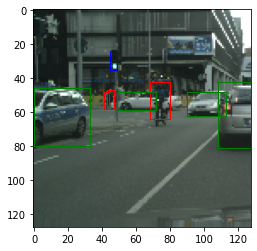

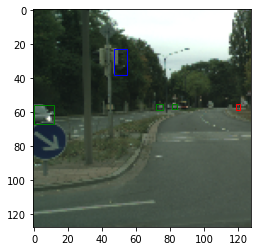

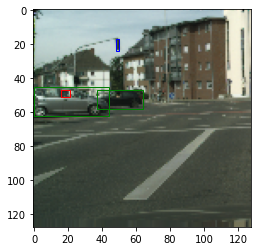

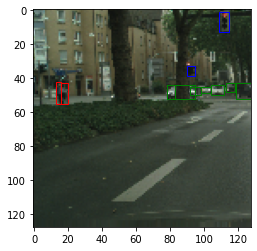

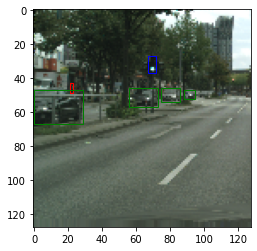

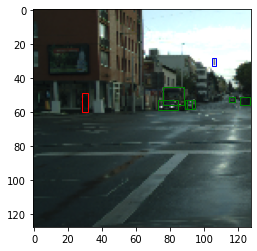

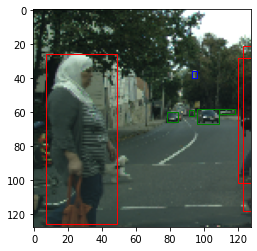

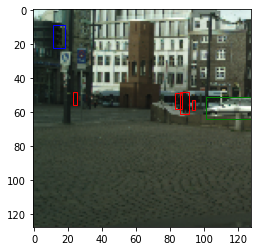

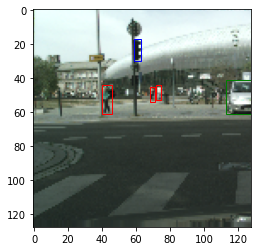

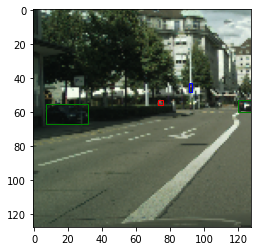

In [ ]:
# Show the chosen image with ground truth bounding boxes visualized.
#Find first 10 images with all 3 classes
count = 0
new_list = []
for i in range(len(raw_labels)):
  obj_list = []
  for ebox in raw_labels[i]:
    if ebox[0] not in obj_list:
      obj_list.append(ebox[0])
  if len(obj_list)==3:
    count+=1
    new_list.append(i)
    if count == 10:
      break

#Plot first 10 images which has all three bounding boxes
print(new_list)
for i in new_list:
  plot_bounding_box(images[i], raw_labels[i]) 

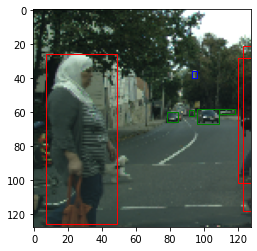

In [ ]:
#Showing one example to visualise the 8x8x8 in the next step
plot_bounding_box(images[59], raw_labels[59]) 

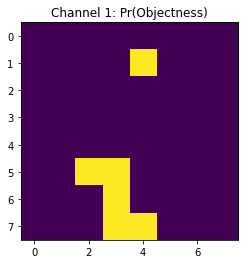

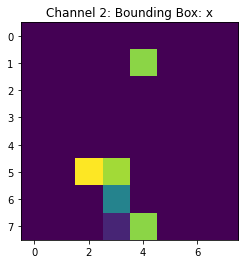

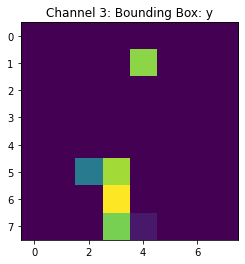

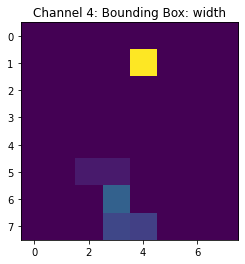

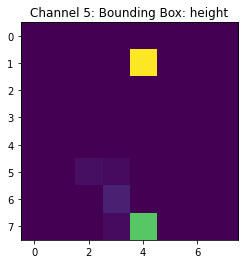

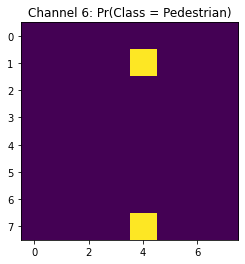

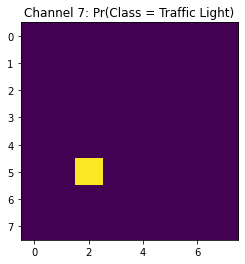

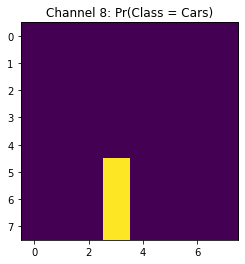

In [ ]:
# Visualize the 8x8x8 representation.
processed_out = process_labels(np.expand_dims(raw_labels[59], axis=0))
titles        = ['Channel 1: Pr(Objectness)','Channel 2: Bounding Box: x','Channel 3: Bounding Box: y','Channel 4: Bounding Box: width',
                 'Channel 5: Bounding Box: height','Channel 6: Pr(Class = Pedestrian)','Channel 7: Pr(Class = Traffic Light)','Channel 8: Pr(Class = Cars)']
i = 0
for each_channel in range(8):
  fig = plt.figure()
  plt.imshow(processed_out[0][each_channel])
  plt.title(titles[i])
  i += 1

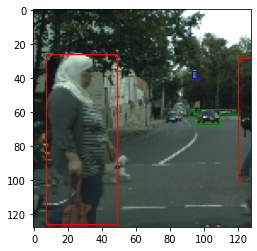

In [ ]:
# Convert back to the original representation (test cases below should pass). 
#Test Case - 59
reconstruct_testcase = reconstruct_raw_labels(processed_out)
plot_bounding_box(images[59], reconstruct_testcase[0]) 

2. Implement the loss function. (3%)

* **Note: The Loss function is implemented above under the heading Loss.
You can find all additional helper functions along with it.**

3. Make block diagram of requested architecture. Label the diagram with the parts of your code which implement each component. Explain any deviations you made from the described architecture. (15%)

* **Note: The only deviations we have made from the described architecture is that we have added a sigmoid layer after the final convolution layer constrain/suppress the values between 0 and 1.** 

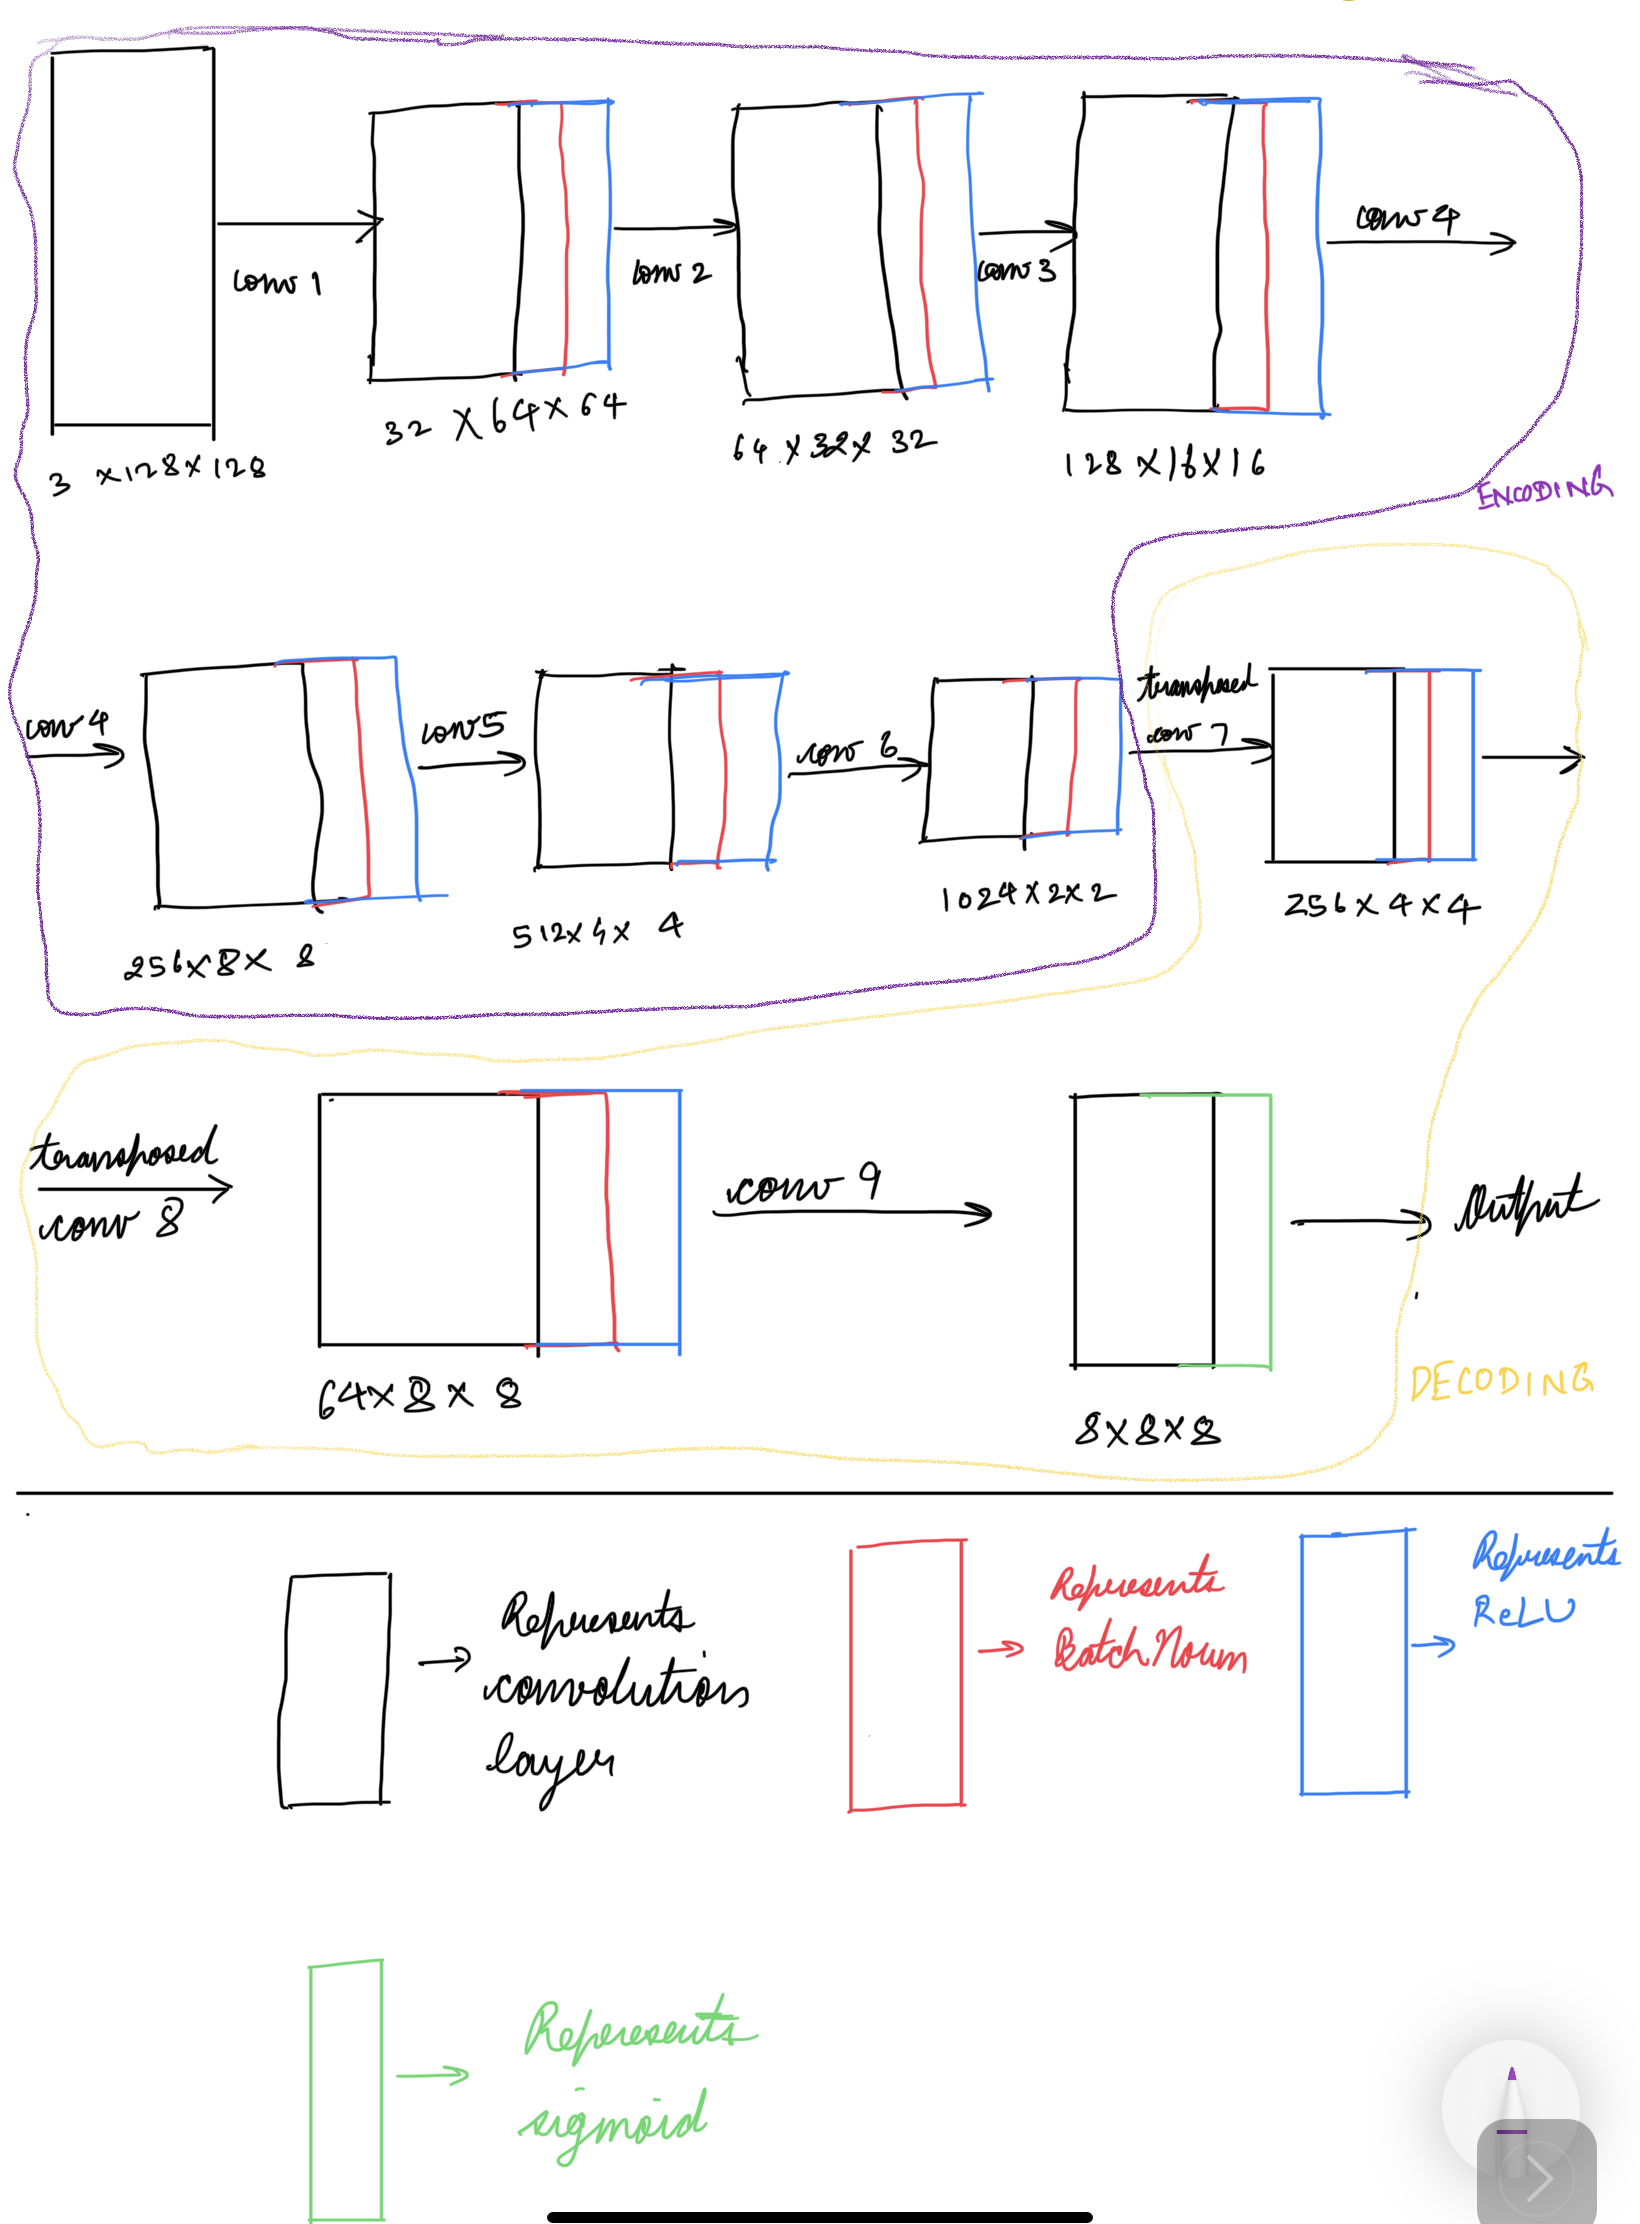

4. Show a plot of the loss over training for your model. (Raw Tensorboard output is not sufficient) (10%) 

* **Note: The model architecture is defined above (after the Loss)**

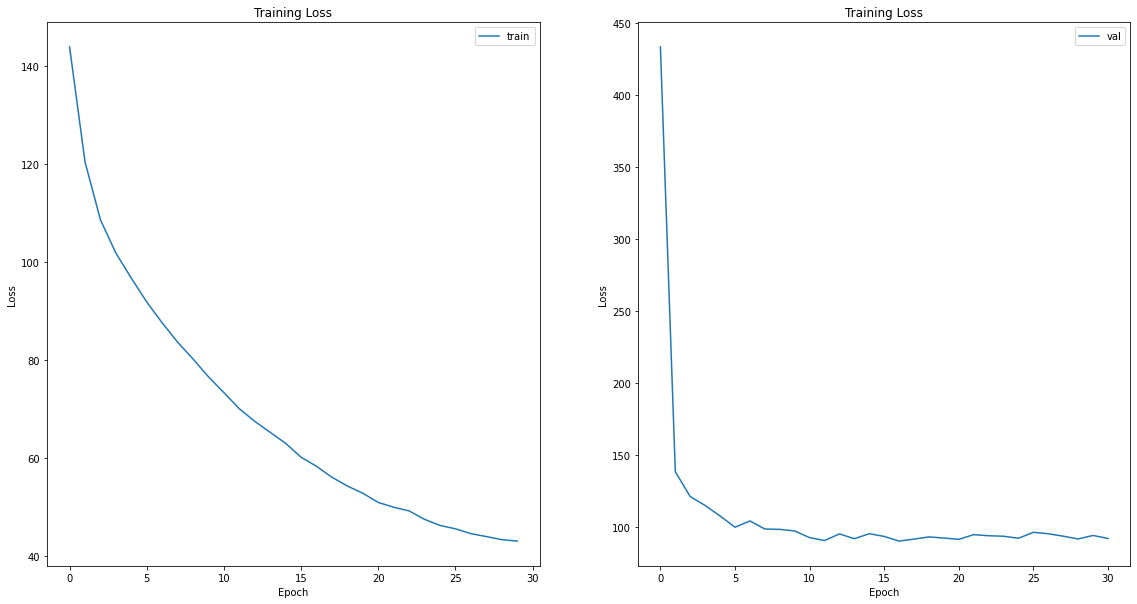

In [ ]:
training_loss_redefined = [lss.detach().cpu().numpy() for lss in model.train_loss]
validation_loss_redefined = [lss.detach().cpu().numpy() for lss in model.val_loss]

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 3, 1)
ax.plot(training_loss_redefined)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend(['train'])
ax = fig.add_subplot(1, 3, 2)
ax.plot(validation_loss_redefined)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend(['val'])
plt.show()

5. Show a plot of the mean Average Precision over training for your model. (10%)

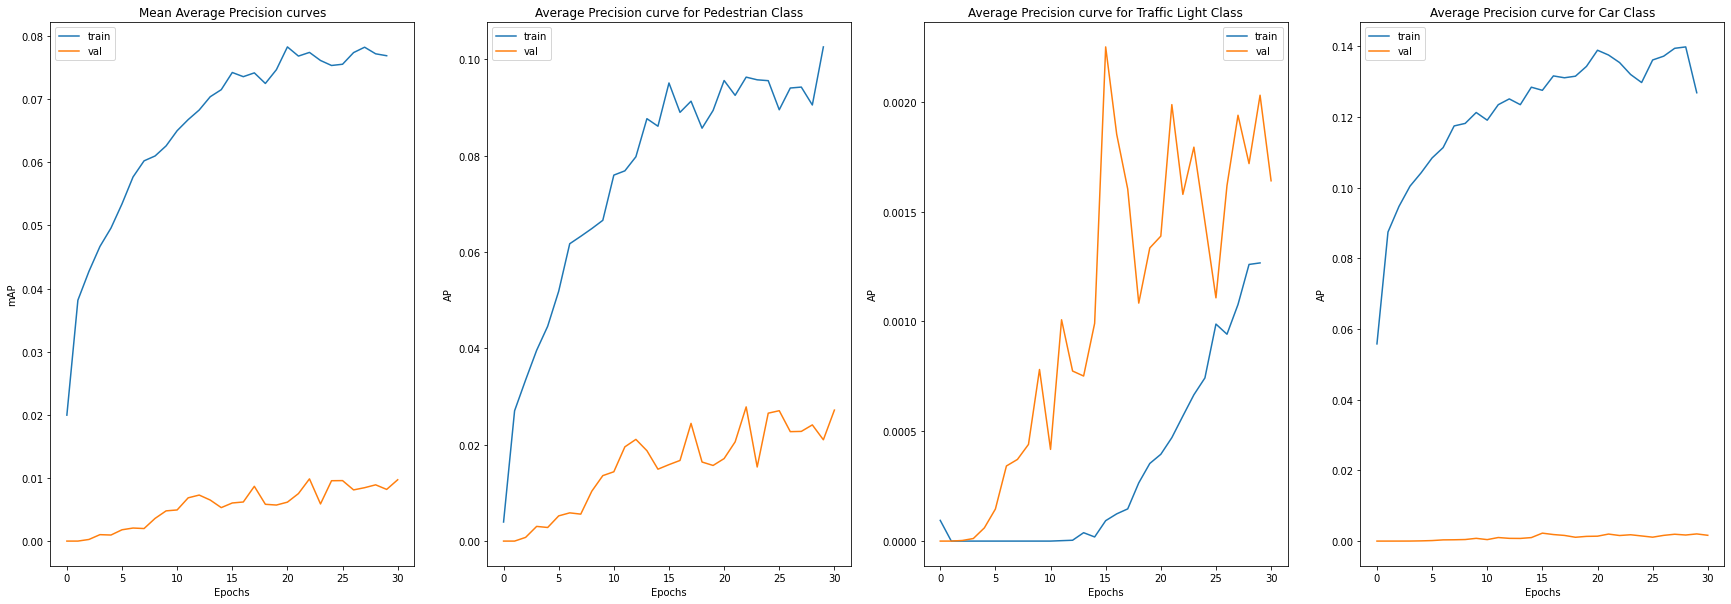

In [ ]:
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 4, 1)
epochs = np.arange(100)
ax.plot(model.train_map)
ax.plot(model.val_map)
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.title('Mean Average Precision curves')
plt.legend(['train', 'val'])
 
ax = fig.add_subplot(1, 4, 2)
ax.plot(model.cl0_batch)
ax.plot(model.cl0_val_batch)
plt.xlabel('Epochs')
plt.ylabel('AP')
plt.title('Average Precision curve for Pedestrian Class')
plt.legend(['train', 'val']) 

ax = fig.add_subplot(1, 4, 3)
ax.plot(model.cl1_batch)
ax.plot(model.cl2_val_batch)
plt.xlabel('Epochs')
plt.ylabel('AP')
plt.title('Average Precision curve for Traffic Light Class')
plt.legend(['train', 'val']) 

ax = fig.add_subplot(1, 4, 4)
ax.plot(model.cl2_batch)
ax.plot(model.cl2_val_batch)
plt.xlabel('Epochs')
plt.ylabel('AP')
plt.title('Average Precision curve for Car Class')
plt.legend(['train', 'val']) 

plt.show()

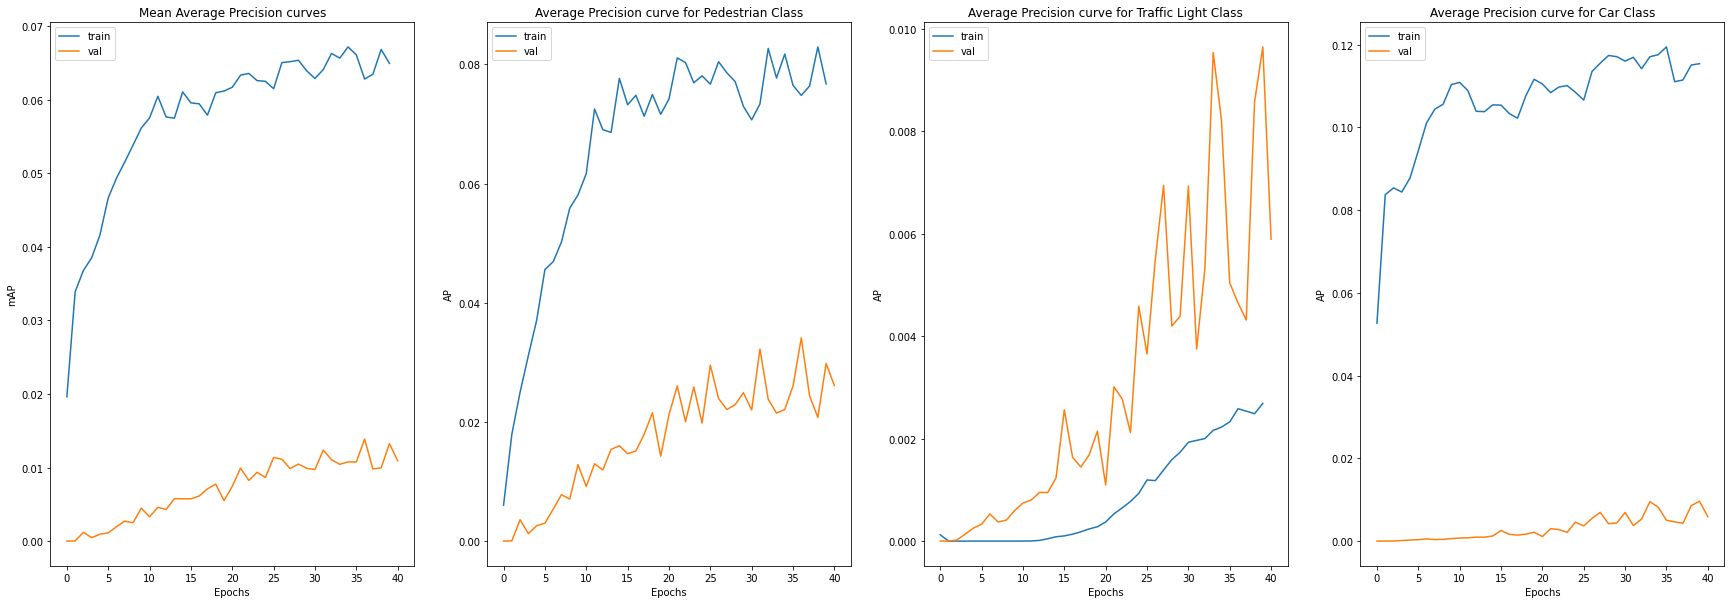

In [28]:
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 4, 1)
epochs = np.arange(100)
ax.plot(model.train_map)
ax.plot(model.val_map)
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.title('Mean Average Precision curves')
plt.legend(['train', 'val'])
 
ax = fig.add_subplot(1, 4, 2)
ax.plot(model.cl0_batch)
ax.plot(model.cl0_val_batch)
plt.xlabel('Epochs')
plt.ylabel('AP')
plt.title('Average Precision curve for Pedestrian Class')
plt.legend(['train', 'val']) 

ax = fig.add_subplot(1, 4, 3)
ax.plot(model.cl1_batch)
ax.plot(model.cl2_val_batch)
plt.xlabel('Epochs')
plt.ylabel('AP')
plt.title('Average Precision curve for Traffic Light Class')
plt.legend(['train', 'val']) 

ax = fig.add_subplot(1, 4, 4)
ax.plot(model.cl2_batch)
ax.plot(model.cl2_val_batch)
plt.xlabel('Epochs')
plt.ylabel('AP')
plt.title('Average Precision curve for Car Class')
plt.legend(['train', 'val']) 

plt.show()

6. For one image in the inference step, show the predicted bounding boxes in the image before performing any elimination. Then, show the annotated image after the low probability bounding boxes are removed. Finally, show image after performing non-max suppression. Label each of these visualizations. See Figure 4 as an example of what this visualization should look like. (15%)

In [67]:
# model = YOLO.load_from_checkpoint('/content/drive/MyDrive/CIS680/HW2/HW2/train_lossepoch=29-train_loss=0.00.ckpt')

Text(0.5, 1.0, 'Post Non-Max Supression')

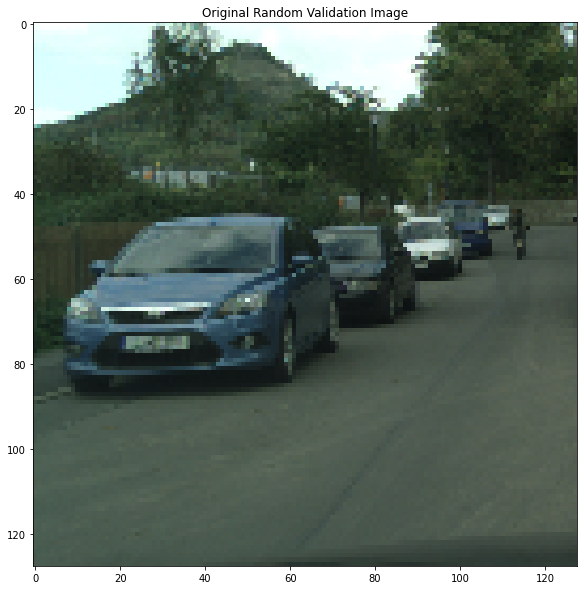

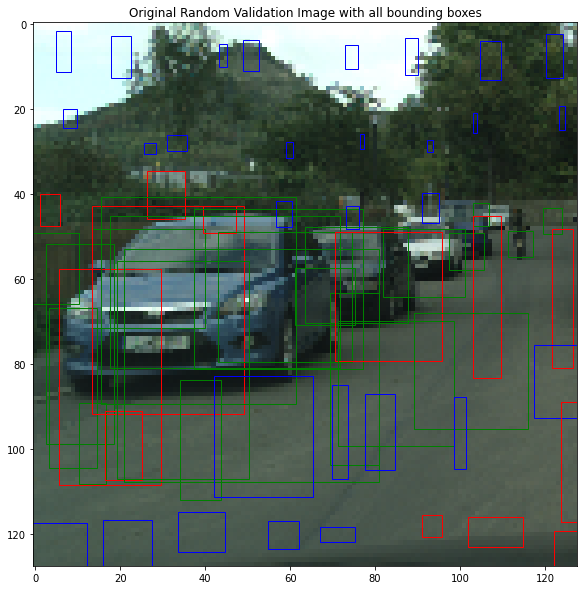

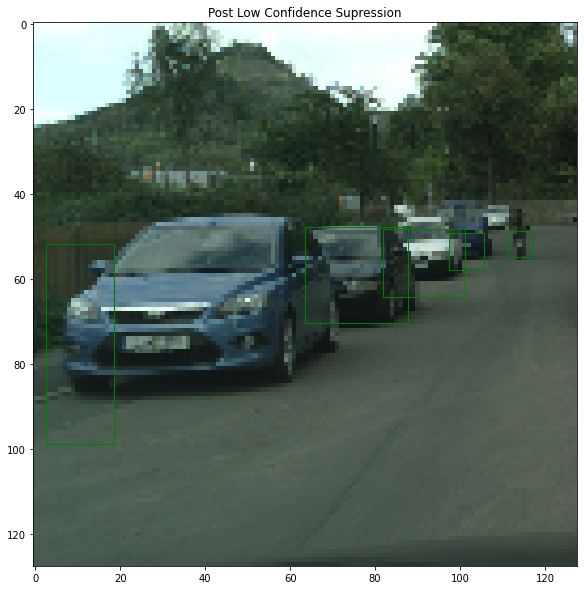

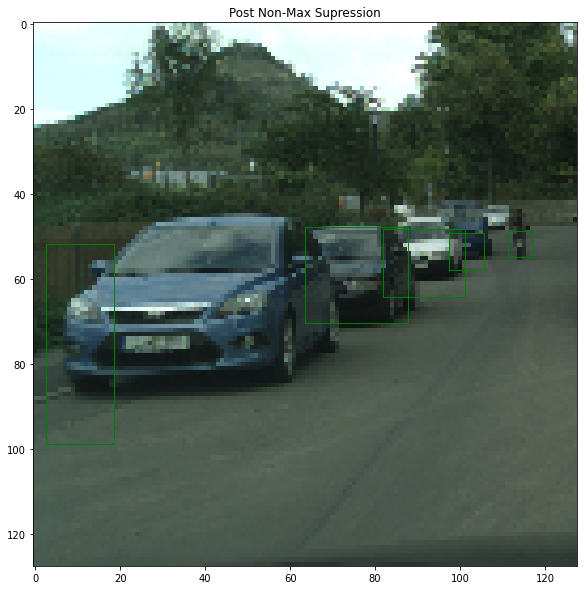

In [61]:
#75, 1075, 7650, 782, 26
images_valid = eval_data[26]
labels_valid = eval_labels[26]

fig = plt.figure(figsize=(30, 10))
image_for_plotting = torch.permute(images_valid, (1, 2, 0)).cpu().detach().numpy()
plt.imshow(np.uint8(image_for_plotting))
plt.title('Original Random Validation Image')

image_valid = torch.unsqueeze(images_valid, 0)
label_valid = torch.unsqueeze(labels_valid, 0)
y_pred = model(image_valid)
y_pred_raw = reconstruct_raw_labels_plotting(y_pred)
y_pred_raw = y_pred_raw[0]
plot_bounding_box(np.uint8(image_for_plotting), y_pred_raw)
plt.title('Original Random Validation Image with all bounding boxes')



y_pred_low_conf         = non_max_suppression_plot(y_pred, return_low_confidence = True)
y_pred_low_conf         = torch.unsqueeze(torch.from_numpy(y_pred_low_conf), 0)
y_pred_low_conf_process = reconstruct_raw_labels_LCS(y_pred_low_conf)
plot_bounding_box(np.uint8(image_for_plotting), y_pred_low_conf_process[0])
plt.title('Post Low Confidence Supression')



y_pred_low_conf         = non_max_suppression_plot(y_pred, return_low_confidence = False)
y_pred_low_conf_process = np.hstack((y_pred_low_conf[0][:, 0].reshape(-1, 1), y_pred_low_conf[0][:, 2:]))

plot_bounding_box(np.uint8(image_for_plotting), y_pred_low_conf_process)
plt.title('Post Non-Max Supression')

7. For one image in the inference step, show the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights as done in Figure 1. Show the precision/recall curves for each class in inference. Write down the achieved mean Average Precision for your inference stage. (17%)

Text(0.5, 1.0, 'Original Bounding boxes from Raw Data')

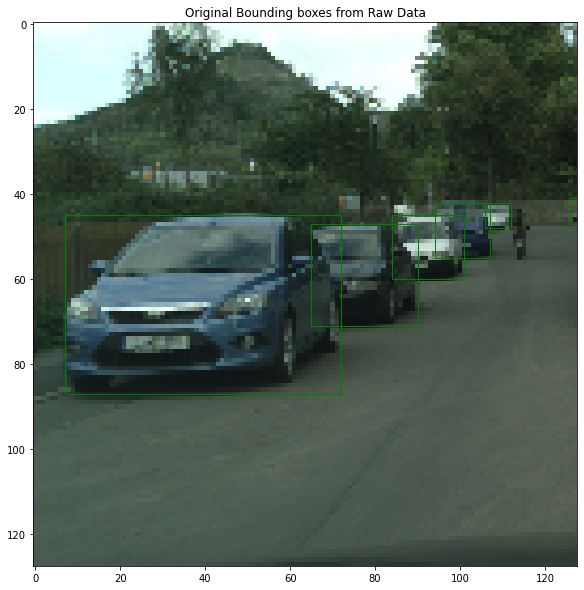

In [65]:
new_label_for_Q7  = labels_valid
new_label_for_Q7  = torch.unsqueeze(new_label_for_Q7, 0)
true_label_for_q7 = reconstruct_raw_labels_plotting(new_label_for_Q7)[0]
plot_bounding_box(np.uint8(image_for_plotting), true_label_for_q7)
plt.title('Original Bounding boxes from Raw Data')

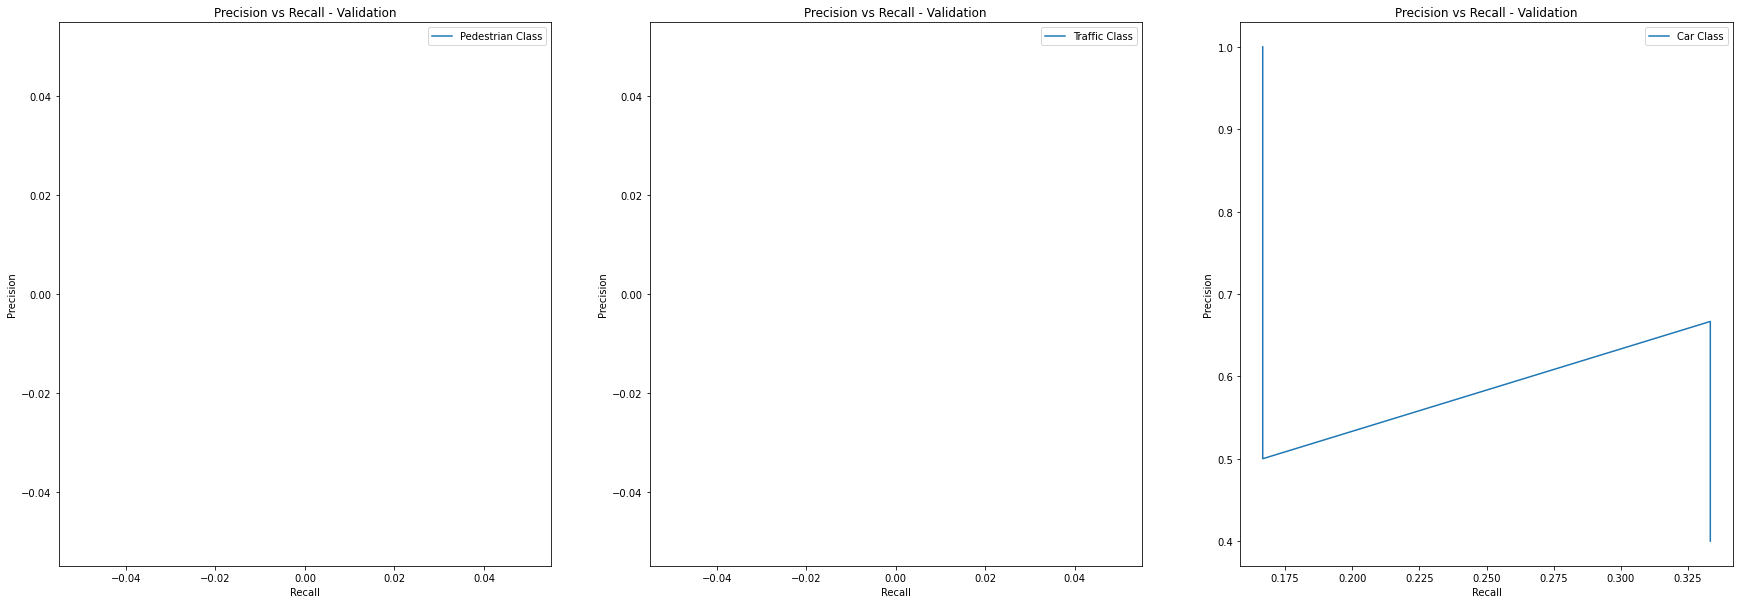

In [66]:
new_prediction    = torch.unsqueeze(y_pred_low_conf[0], 0)
new_label_for_Q7 = torch.hstack((true_label_for_q7[:,0].reshape(-1,1), torch.ones(true_label_for_q7.shape[0]).reshape(-1,1), true_label_for_q7[:,1:]))
new_label_for_Q7 = torch.unsqueeze(new_label_for_Q7, 0)

rec0, pr0 = precision_recall_curve(new_prediction, new_label_for_Q7, 0)
rec1, pr1 = precision_recall_curve(new_prediction, new_label_for_Q7, 1)
rec2, pr2 = precision_recall_curve(new_prediction, new_label_for_Q7, 2)

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 3, 1)
ax.plot(rec0,pr0)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall - Validation")
plt.legend(['Pedestrian Class'])

ax = fig.add_subplot(1, 3, 2)
ax.plot(rec1,pr1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall - Validation")
plt.legend(['Traffic Class'])

ax = fig.add_subplot(1, 3, 3)
ax.plot(rec2,pr2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall - Validation")
plt.legend(['Car Class'])

plt.show()

Precision Recall Curve along the entire validation Dataset

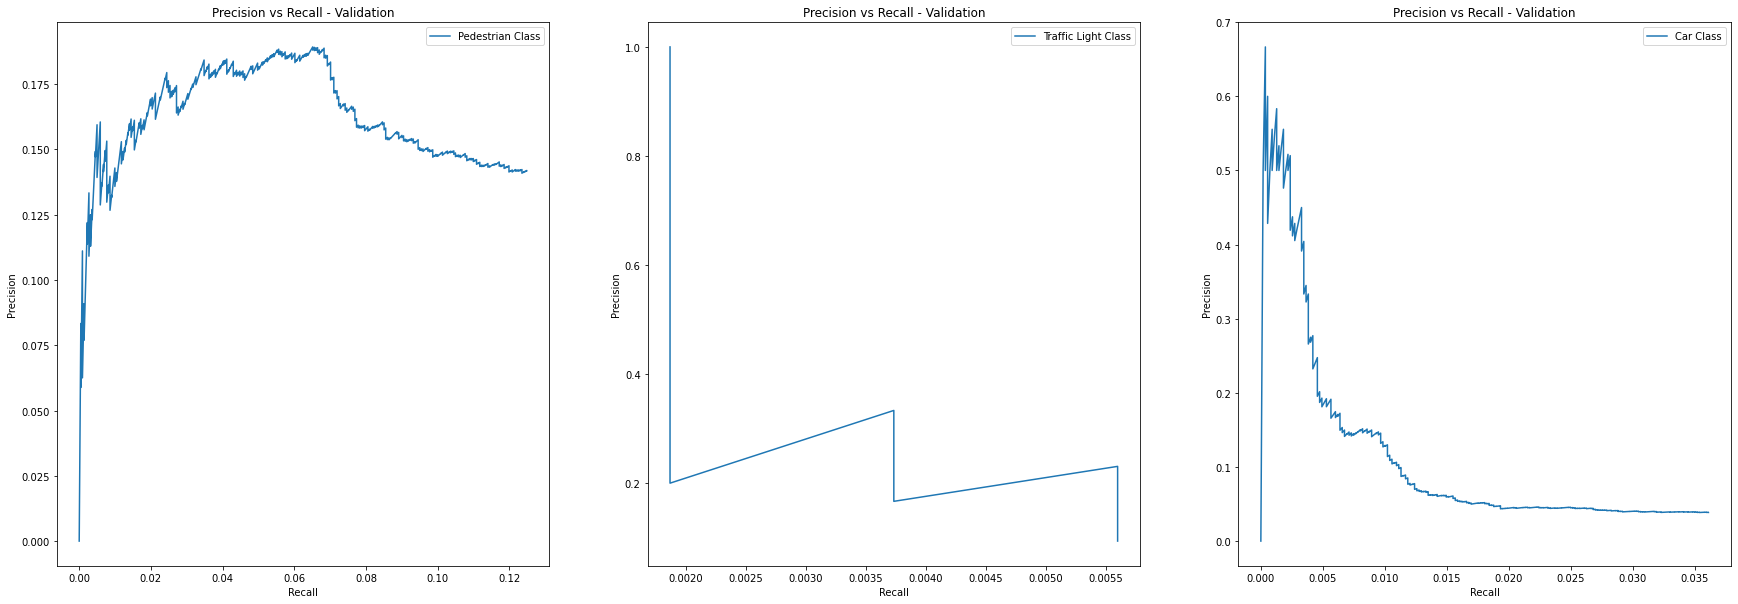

In [ ]:
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 3, 1)
ax.plot(model.val_recall_cl0[0], model.val_precision_cl0[0])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall - Validation")
plt.legend(['Pedestrian Class'])
ax = fig.add_subplot(1, 3, 2)
ax.plot(model.val_recall_cl1[0], model.val_precision_cl1[0])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall - Validation")
plt.legend(['Traffic Light Class'])
ax = fig.add_subplot(1, 3, 3)
ax.plot(model.val_recall_cl1[1], model.val_precision_cl1[1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall - Validation")
plt.legend(['Car Class'])
plt.show()

8. Explain any issues or challenges you had with your implementation. Explain the performance you achieved and any interesting observations you made while training your network. Discuss hypotheses for how you could improve the performance of your implementation further. (20%)

Given the substantially lower training loss compared to the validation loss and the significantly bigger training mAP compared to the validation map, the main issue is the dataset is too small to work on and splitting the small dataset leads to overfitting. We tried  altering the network architecture, drastically increased the number of epochs (took for ever with colab) and we also changed the optimizer to perform with different learning rates and weight decays but it didnt work. 

Another issue was an imbalance in class labels. It would have been better if we could have maybe seperated out the model to learn each class individually (just a thought). For example, few images had very few traffic lights and more cars or vice versa. By viewing the 8x8x8 output and concentrating on the different depths (objectness, probability of classes etc) we could see that the model does improve over time and does improve predictions over a period of time but the number of false positives always kept fluctuating (example: where the objectness should be 0 with respect to the target, the predictions are close to 1 in very few cases).

The IOU kept penalizing the ability to predict for the pedestrian and traffic light classes while computing the YOLO Loss. So getting rid of them in the third and fourth term of the Yolo loss significantly helped improve the performance. Also, we had to define various reconstruction cases for each sort of data we were dealing with and that was pretty annoying.


## Some Useful Online Materials

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output. 

For part (a), your submission should consist of this file and a pdf report. This report can simply be a pdf version of this document. Example conversion code below.

**Please save before exporting!**

In [78]:
# Saving npz file
last_train = int((0.8 * len(images)) - 1)
new_eval_indices = np.arange((last_train + 1), len(images)).tolist()
print(type(new_eval_indices))
print(len(new_eval_indices))

all_predictions = torch.tensor([]).to(device)
for each_tensor in model.val_predstore:
  all_predictions = torch.cat((all_predictions, each_tensor))
# print("all", all_predictions.shape)

predictions_list = list([None] * len(images))

for i in range(len(predictions_list)):
  if i in new_eval_indices:
    all_pred_idx = new_eval_indices.index(i)

    current_prediction = all_predictions[all_pred_idx]
    current_prediction = torch.unsqueeze(current_prediction, 0)
    nms_label = non_max_suppression_plot(current_prediction, return_low_confidence=False)
    if len(nms_label[0]) == 0:
      predictions_list[i] = None
    else:
      predictions_list[i] = nms_label[0].cpu().detach().numpy()

np.savez("Predictions",np.array(predictions_list, dtype = object))

<class 'list'>
1980


In [81]:
!sudo apt-get update &> /dev/null
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended &> /dev/null
!jupyter nbconvert --Application.log_level=10 --output-dir='/content/content_new' --to pdf HW2final_josh.ipynb

[NbConvertApp] Searching ['/content', '/root/.jupyter', '/root/.local/etc/jupyter', '/usr/etc/jupyter', '/usr/local/etc/jupyter', '/etc/jupyter'] for config files
[NbConvertApp] Looking for jupyter_config in /etc/jupyter
[NbConvertApp] Looking for jupyter_config in /usr/local/etc/jupyter
[NbConvertApp] Looking for jupyter_config in /usr/etc/jupyter
[NbConvertApp] Looking for jupyter_config in /root/.local/etc/jupyter
[NbConvertApp] Looking for jupyter_config in /root/.jupyter
[NbConvertApp] Looking for jupyter_config in /content
[NbConvertApp] Looking for jupyter_nbconvert_config in /etc/jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in /usr/local/etc/jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in /usr/etc/jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in /root/.local/etc/jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in /root/.jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in /content
[NbConvertApp] WARNING | pattern 